In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd

### Check if cuda is available

In [2]:
torch.cuda.is_available()

True

### Cifar10 dataset 

In [3]:
cifar = load_dataset("cifar10",)
i = cifar["train"]["img"][0]
print(i.size)

(32, 32)


Images in cifar10 has small size 32 x 32 which is faster for training. Moreover, the dataset has 10 classes and we can see that both train and test datasets are balanced with equal number of smaples per class

In [4]:
df_train = pd.DataFrame(cifar["train"])
df_train.groupby(by="label").count()

,img
label,
0,5000
1,5000
2,5000
3,5000
4,5000
5,5000
6,5000
7,5000
8,5000


In [5]:
df_test = pd.DataFrame(cifar["test"])
df_test.groupby(by="label").count()

,img
label,
0,1000
1,1000
2,1000
3,1000
4,1000
5,1000
6,1000
7,1000
8,1000


Names of classes

In [6]:
labels = cifar["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
    
print(labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### The Model Architecture

In [7]:
class NaturalSceneClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(4096,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    
    def forward(self, xb):
        return self.network(xb)

### Dataset Class

In [8]:
transform = transforms.Compose([
    # you can add other transformations in this list
     transforms.Resize((32,32)),
    transforms.ToTensor()
])

class Dataset(Dataset):
    
    # Constructor 
    def __init__(self, X_data, Y_data, transform=transform):
        self.len = len(X_data)
        self.x = X_data
        self.y = Y_data
        self.transform = transform
             
    # Getter
    def __getitem__(self, index):
        x = self.x[index] 
        y = self.y[index]
        if self.transform:
            x = self.transform(x)     
        return x, y
    
    # Get Length
    def __len__(self):
        return self.len


Choosing the Optimizer and the Cost function

In [14]:
model = NaturalSceneClassification()
model.to("cuda:0")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_new = nn.CrossEntropyLoss()
num_epoch = 20
batch_size = 256

We will also add a validation set with balanced number of samples in each class.

In [11]:
dataset_val = Dataset( X_data = cifar["train"]["img"][0:10000], Y_data = cifar["train"]["label"][0:10000])
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True)
dataset_train = Dataset( X_data = cifar["train"]["img"][10000:-1], Y_data = cifar["train"]["label"][10000:-1])
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = Dataset( X_data = cifar["test"]["img"], Y_data = cifar["test"]["label"])
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)

Preview an image from the dataset

Label : 7


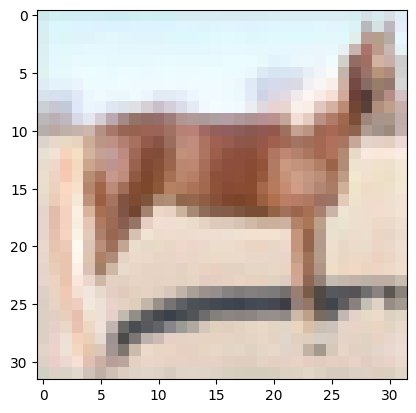

In [13]:
img,label = dataset_train[10]

def display_img(img,label):
    print(f"Label : {label}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(img, label)

### Training the model

We will compute the training and validation losses. We also added early stopping to avoid over-fitting. 
If the validation loss is not decreasing, the training will stop after "patience" number of epochs.

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

best_loss = float('inf')
#best_model_weights = None
patience = 3

epoch_train_loss = []
epoch_train_acc = []
epoch_val_loss = []
epoch_val_acc = []

for epoch in range(num_epoch):

    train_losses = []
    train_acc = []

    val_losses = []
    val_acc = []
    val_loss_total = 0
    
    
    
    model.train()
    for x,y in train_loader:

        optimizer.zero_grad()
        x = x.to("cuda:0")
        y = y.to("cuda:0")
        output = model(x)
        loss = loss_new(output, y)
        acc = accuracy(output, y)
        
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_acc.append(acc.item())
        
    epoch_train_loss.append(sum(train_losses)/len(train_losses))
    epoch_train_acc.append(sum(train_acc)/len(train_acc))
    
        

    print(f"Train epoch {epoch} loss:", "{:.4f}".format(sum(train_losses)/len(train_losses)), "acc", "{:.4f}".format(sum(train_acc)/len(train_acc)))
    
    model.eval()
    with torch.no_grad():
        for x,y in val_loader:

            
            x = x.to("cuda:0")
            y = y.to("cuda:0")
            output = model(x)
            loss = loss_new(output, y)
            acc = accuracy(output, y)
            

            val_losses.append(loss.item())
            val_acc.append(acc.item())
            
    epoch_val_loss.append(sum(val_losses)/len(val_losses))
    epoch_val_acc.append(sum(val_acc)/len(val_acc))
    
    
    print(f"Valid epoch {epoch} loss:", "{:.4f}".format(sum(val_losses)/len(val_losses)), "acc", "{:.4f}".format(sum(val_acc)/len(val_acc)),"\n")
    
    
    # Early stopping
    val_loss_total = sum(val_losses)/len(val_losses)
    if val_loss_total < best_loss:
        best_loss = val_loss_total
        patience = 3  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            break
    



Train epoch 0 loss: 2.0535 acc 0.2172
Valid epoch 0 loss: 1.7123 acc 0.3699 

Train epoch 1 loss: 1.5134 acc 0.4400
Valid epoch 1 loss: 1.4565 acc 0.4557 

Train epoch 2 loss: 1.2562 acc 0.5390
Valid epoch 2 loss: 1.2043 acc 0.5628 

Train epoch 3 loss: 1.0696 acc 0.6132
Valid epoch 3 loss: 1.1274 acc 0.5983 

Train epoch 4 loss: 0.9341 acc 0.6663
Valid epoch 4 loss: 0.9397 acc 0.6725 

Train epoch 5 loss: 0.8173 acc 0.7108
Valid epoch 5 loss: 0.8680 acc 0.6979 

Train epoch 6 loss: 0.7278 acc 0.7406
Valid epoch 6 loss: 0.8683 acc 0.6991 

Train epoch 7 loss: 0.6594 acc 0.7651
Valid epoch 7 loss: 0.7975 acc 0.7266 

Train epoch 8 loss: 0.5770 acc 0.7974
Valid epoch 8 loss: 0.7621 acc 0.7385 

Train epoch 9 loss: 0.5075 acc 0.8199
Valid epoch 9 loss: 0.7420 acc 0.7506 

Train epoch 10 loss: 0.4404 acc 0.8446
Valid epoch 10 loss: 0.7614 acc 0.7540 

Train epoch 11 loss: 0.3881 acc 0.8623
Valid epoch 11 loss: 0.8560 acc 0.7506 

Train epoch 12 loss: 0.3238 acc 0.8841
Valid epoch 12 loss: 

Plot Training vs. Validation loss:

This way we can check for overfitting or underfitting

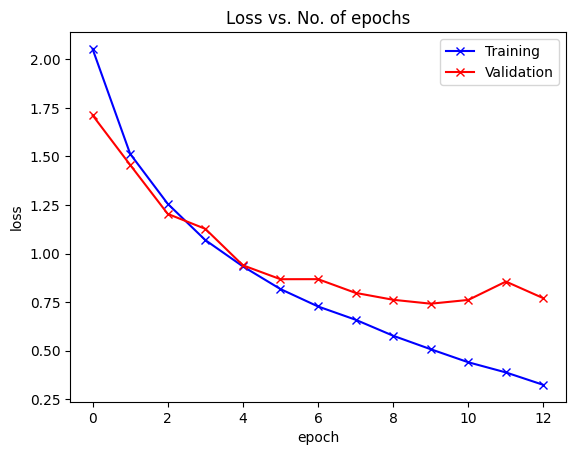

In [16]:
def plot_losses(epoch_train_loss, epoch_val_loss):
    """ Plot the losses in each epoch"""
    plt.plot(epoch_train_loss, '-bx')
    plt.plot(epoch_val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(epoch_train_loss,epoch_val_loss)


Plot Training vs. Validation Accuracy

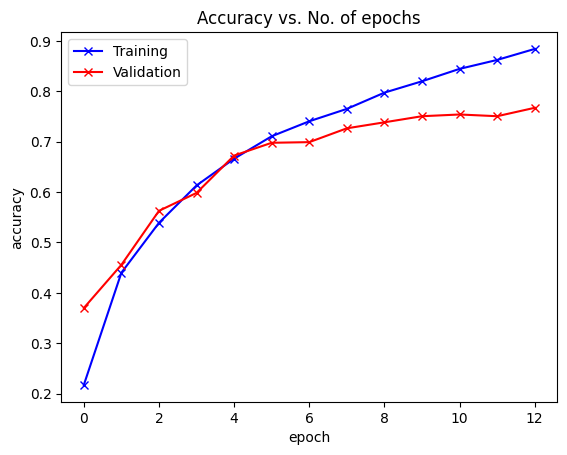

In [17]:
def plot_accuracy(epoch_train_acc, epoch_val_acc):
    """ Plot the accuracy in each epoch"""
    plt.plot(epoch_train_acc, '-bx')
    plt.plot(epoch_val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

plot_accuracy(epoch_train_acc,epoch_val_acc)


#### Evaluating the model on the test data

In [18]:
model.eval()
with torch.no_grad():
    
    test_losses = []
    test_acc = []
    
    for x,y in test_loader:
        
        x = x.to("cuda:0")
        y = y.to("cuda:0")
        output = model(x)
        
        loss = loss_new(output, y)
        acc = accuracy(output, y)
        
        test_losses.append(loss.item())
        test_acc.append(acc.item())

    print("epoch loss", sum(test_losses)/len(test_losses), "acc", sum(test_acc)/len(test_acc))

epoch loss 0.7507351115345955 acc 0.7666015625


Saving the model

In [19]:
torch.save(model.state_dict(), 'model.pth')